In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian, quantile_s2p
import time as time
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
import orbax.checkpoint
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Function Definitions

In [4]:
def find_coverage_calib(y, y_upper_all, y_lower_all, ci, flag=False):
    q_hats = []
    times = []
    E_is = []
    random_seed = 42
    np.random.seed(random_seed)
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                q_hats.append(0)
                continue
            initial_upper = y_upper_all[i]
            initial_lower = y_lower_all[i]
            upper_err = np.array(y).reshape(-1) - \
                np.array(initial_upper).reshape(-1)
            lower_err = np.array(initial_lower).reshape(-1) - \
                np.array(y).reshape(-1)
            E_i = np.max(np.vstack((lower_err, upper_err)), axis=0)
            # E_i = E_i + np.random.normal(0, 10, len(E_i))

            E_is.append(E_i)
            q_level = np.ceil((len(y)+1)*ci[i])/len(y)
            q_hat = np.quantile(E_i, q_level, method='higher')
            q_hats.append(q_hat)
            upper = initial_upper + q_hat
            lower = initial_lower - q_hat
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats, times, E_is

In [5]:
def find_coverage_train_test(y, y_upper_all, y_lower_all, ci, q_hats, flag=False):
    coverage = np.zeros(len(ci))
    if flag == False:
        for i in range(len(ci)):
            upper = y_upper_all[i]
            lower = y_lower_all[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    else:
        for i in range(len(ci)):
            if ci[i] == 0 or ci[i] == 1:
                coverage[i] = ci[i]
                continue
            upper = y_upper_all[i] + q_hats[i]
            lower = y_lower_all[i] - q_hats[i]
            coverage[i] = np.sum((y >= lower) & (
                y <= upper)) / len(y)
    return coverage, q_hats

In [6]:
def calib_errors(ci, coverages):
    ece = 0.0
    ace = 0.0
    for i in range(len(ci)):
        ace += abs(ci[i]-coverages[i])
    ece = ace/len(ci)
    return ace, ece

In [7]:
def get_trained_model(ci, x_train, y_train):
    alpha = 1 - ci
    lower_params_all = []
    upper_params_all = []
    lower_model_all = []
    upper_model_all = []
    for i in range(len(ci)):
        # define model
        lower_model = quantile_s2p.QuantileRegression(alpha=alpha[i]/2)
        upper_model = quantile_s2p.QuantileRegression(alpha=1 - alpha[i]/2)

        # initialize model and train
        lower_params = lower_model.init(jax.random.PRNGKey(0), x_train, True)
        lower_params, lower_losses = fit(lower_model, lower_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        upper_params = upper_model.init(jax.random.PRNGKey(0), x_train, True)
        upper_params, upper_losses = fit(upper_model, upper_params, x_train, y_train, False,
                                         batch_size=1024, learning_rate=0.0001, epochs=50)
        lower_model_all.append(lower_model)
        upper_model_all.append(upper_model)
        lower_params_all.append(lower_params)
        upper_params_all.append(upper_params)
    return lower_params_all, upper_params_all, lower_model_all, upper_model_all

In [8]:
def get_all(ci, x, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler):
    lower_all = []
    upper_all = []
    for i in range(len(ci)):
        # get predictions x = {cal, test}
        y_hat_lower = lower_model_all[i].apply(lower_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        y_hat_upper = upper_model_all[i].apply(upper_params_all[i], x, False, rngs={
            "dropout": jax.random.PRNGKey(0)})
        mean_upper = scaler.inverse_transform(y_hat_upper)
        mean_lower = scaler.inverse_transform(y_hat_lower)
        lower_all.append(mean_lower)
        upper_all.append(mean_upper)
    return lower_all, upper_all

# Model Training

In [9]:
train = {1: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    3: {
    'start_time': "2011-04-19",
    'end_time': "2011-05-22"
},
    2: {
    'start_time': "2011-04-21",
    'end_time': "2011-05-21"
},
    5: {
    'start_time': "2011-04-22",
    'end_time': "2011-06-01"
}}
test = {6: {
    'start_time': "2011-05-25",
    'end_time': "2011-06-13"
}}
appliances = ["Refrigerator"]
# train = {
#     1: {
#         'start_time': "2011-04-28",
#         'end_time': "2011-05-15"
#     },
#     3: {
#         'start_time': "2011-04-19",
#         'end_time': "2011-05-22"
#     }
# }
# test = {
#     2: {
#         'start_time': "2011-04-21",
#         'end_time': "2011-05-21"
#     }
# }
# appliances = ["Microwave"]

# train = {
#     1: {
#         'start_time': "2011-04-28",
#         'end_time': "2011-05-15"
#     },
#     3: {
#         'start_time': "2011-04-19",
#         'end_time': "2011-05-22"
#     }
# }
# test = {
#     2: {
#         'start_time': "2011-04-21",
#         'end_time': "2011-05-21"
#     }
# }
# appliances = ["Dish Washer"]

In [10]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

KeyboardInterrupt: 

In [12]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [13]:
y_true_cal = scaler_y.inverse_transform(y_cal)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [14]:
csv_data = pd.read_csv(
    "/home/haikoo.khandor/haikoo/Final_ConformalNILM/normal/datasets/Building1_NILM_data_basic.csv")

In [15]:
csv_data.dropna(inplace=True)

In [16]:
csv_data.head()

,Timestamp,main,Refrigerator,Dish Washer,Microwave,Washer Dryer
1,2011-04-18 09:22:00-04:00,342.50726,6.0000,0.142857,5.0000,0.00000
2,2011-04-18 09:23:00-04:00,345.53015,6.0000,0.285714,5.0000,0.00000
3,2011-04-18 09:24:00-04:00,345.14550,6.0000,0.437500,5.0000,0.00000
4,2011-04-18 09:25:00-04:00,342.37317,5.9375,0.187500,4.7500,0.12500
5,2011-04-18 09:26:00-04:00,342.24600,5.9375,0.500000,4.9375,0.15625


In [17]:
from tueplots import bundles

In [18]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

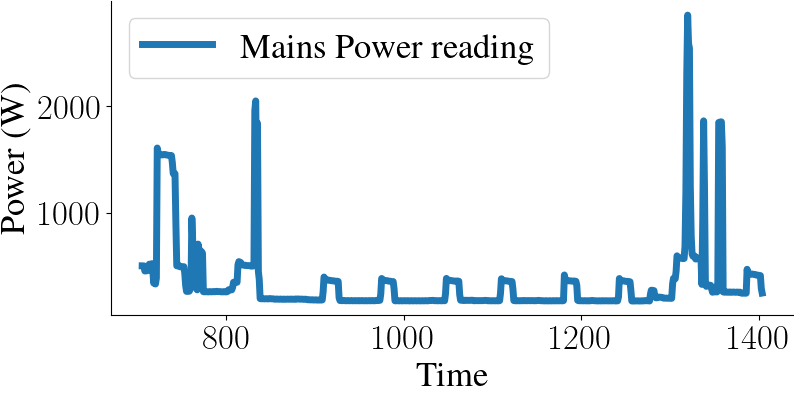

In [59]:
plt.rcParams.update(bundles.icml2022())
# plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.fontsize': 25, 'legend.title_fontsize': 25, 'axes.labelsize': 25,
                    'xtick.labelsize': 25, 'ytick.labelsize': 25, 'axes.titlesize': 25, 'figure.figsize': (8, 4)})
plt.plot(csv_data['main'][700:1400], label='Mains Power reading', linewidth=5)
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.legend()
sns.despine()
# plt.show()
plt.savefig('/home/haikoo.khandor/haikoo/Final_ConformalNILM/normal/notebooks/fridge/s2p/gmlp/mains_power_reading2.pdf')

# Before Calibration

In [19]:
from models import seq2point_gaussian
model = seq2point_gaussian.seq2point()
params = model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False,
                     batch_size=1024, learning_rate=0.0001, epochs=50)

In [26]:
from flax.training import orbax_utils
from flax.training import train_state
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

In [28]:

state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optax.adam(0.001),
)

In [31]:
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager, CheckpointManagerOptions
ckpt_dir = "/home/haikoo.khandor/haikoo/Final_ConformalNILM/normal/notebooks/fridge/s2p/gmlp/checkpoints"
checkpointer = PyTreeCheckpointer()
options = CheckpointManagerOptions(max_to_keep=3, create=True)  # Keep last 3 checkpoints
checkpoint_manager = CheckpointManager(ckpt_dir, checkpointer, options) 
ckpt_data = {'state': state}
checkpoint_manager.save(1, ckpt_data)

True

In [20]:
y_hat_train = model.apply(params, x_train, True, rngs={
    "dropout": jax.random.PRNGKey(0)})
train_mean = scaler_y.inverse_transform(y_hat_train[0])
train_sigma = scaler_y.scale_*y_hat_train[1]
y_train_scaled = scaler_y.inverse_transform(y_train)

In [21]:
ci = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

In [22]:
lower_params_all, upper_params_all, lower_model_all, upper_model_all = get_trained_model(
    ci, x_train, y_train)

In [19]:
lower_train_all, upper_train_all = get_all(
    ci, x_train, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_test_all, upper_test_all = get_all(
    ci, x_test, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)
lower_cal_all, upper_cal_all = get_all(
    ci, x_cal, lower_params_all, upper_params_all, lower_model_all, upper_model_all, scaler_y)

11

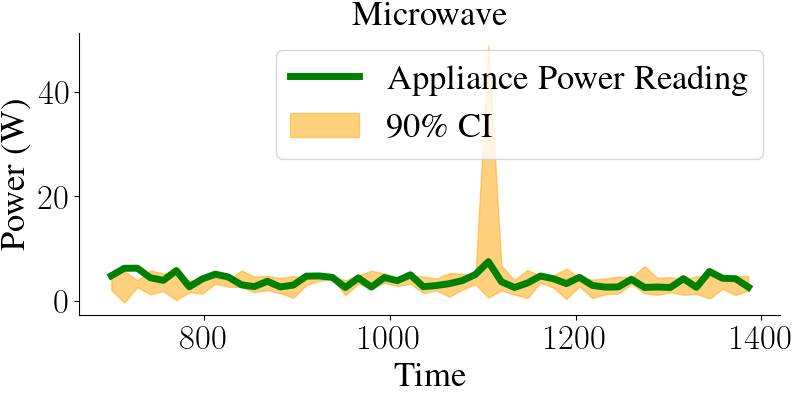

In [22]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'legend.fontsize': 25, 'legend.title_fontsize': 25, 'axes.labelsize': 25,
                    'xtick.labelsize': 25, 'ytick.labelsize': 25, 'axes.titlesize': 25, 'figure.figsize': (8, 4)})
# plt.figsize=(20, 10)
plt.plot(np.arange(700, 1400, 14),
         train_mean[500:550], label='Appliance Power Reading', color='green', linewidth=5)
plt.fill_between(np.arange(700, 1400, 14), lower_train_all[9][500:550].reshape(
    -1), upper_train_all[9][500:550].reshape(-1), alpha=0.5, color='orange', label='90\% CI')
plt.xlabel('Time')
plt.ylabel('Power (W)')
plt.title('Microwave')
# change the x-label to 700-1400 values
# plt.xticks(np.arange(700, 1400, 50), np.arange(700, 1400, 50))
plt.legend()
sns.despine()
# plt.show()

plt.savefig('/home/haikoo.khandor/haikoo/Final_ConformalNILM/normal/notebooks/fridge/s2p/gmlp/microwave_power_reading2.pdf')

In [16]:
initial_coverages_cal, _, _, _ = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci)
initial_coverages_train, _ = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, [])
initial_coverages_test, _ = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, [])

In [17]:
initial_coverages_cal

array([0.        , 0.13469021, 0.19986531, 0.21049087, 0.33769829,
       0.42831488, 0.52544148, 0.65736306, 0.78524394, 0.85677941,
       1.        ])

In [18]:
initial_coverages_test

array([0.        , 0.08414278, 0.14993148, 0.21554139, 0.26100948,
       0.33460462, 0.41004708, 0.52815688, 0.57904774, 0.76777309,
       1.        ])

In [19]:
initial_coverages_train

array([0.        , 0.13880575, 0.20931857, 0.2202185 , 0.35091789,
       0.44086102, 0.54023247, 0.6846503 , 0.81023646, 0.8713459 ,
       1.        ])

# After Calibration

### Conformal Prediction

In [20]:
flag = True
final_coverages_cal, q_hats, times, Errors_all_cal = find_coverage_calib(
    y_true_cal, upper_cal_all, lower_cal_all, ci, flag=flag)
final_coverages_train, q_hats = find_coverage_train_test(
    y_train_scaled, upper_train_all, lower_train_all, ci, q_hats, flag=flag)
final_coverages_test, q_hats = find_coverage_train_test(
    y_test, upper_test_all, lower_test_all, ci, q_hats, flag=flag)

In [21]:
ace_init_cal, ece_init_cal = calib_errors(ci, initial_coverages_cal)
ace_fin_cal, ece_fin_cal = calib_errors(ci, final_coverages_cal)
print('Calibration:')
print(f'Initial ace error is {ace_init_cal} and ece error is {ece_init_cal}')
print(f'Final ace error is {ace_fin_cal} and ece error is {ece_fin_cal}')

Calibration:
Initial ace error is 0.4334929661777911 and ece error is 0.03940845147070828
Final ace error is 0.0011224184375935309 and ece error is 0.00010203803978123008


In [22]:
ace_init_train, ece_init_train = calib_errors(ci, initial_coverages_train)
ace_fin_train, ece_fin_train = calib_errors(ci, final_coverages_train)
print('Train:')
print(
    f'Initial ace error is {ace_init_train} and ece error is {ece_init_train}')
print(f'Final ace error is {ace_fin_train} and ece error is {ece_fin_train}')

Train:
Initial ace error is 0.3501346902125112 and ece error is 0.031830426382955565
Final ace error is 0.13820712361568374 and ece error is 0.012564283965062158


In [23]:
ace_init_test, ece_init_test = calib_errors(ci, initial_coverages_test)
ace_fin_test, ece_fin_test = calib_errors(ci, final_coverages_test)
print('Test:')
print(f'Initial ace error is {ace_init_test} and ece error is {ece_init_test}')
print(f'Final ace error is {ace_fin_test} and ece error is {ece_fin_test}')

Test:
Initial ace error is 1.1697454527020454 and ece error is 0.10634049570018594
Final ace error is 0.9102257415652275 and ece error is 0.08274779468774796


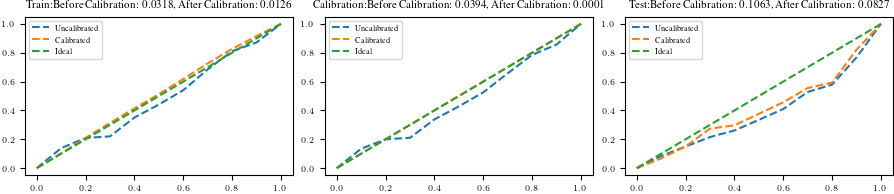

In [24]:
# Train
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (9, 2)})
plt.subplot(1, 3, 1)
plt.plot(ci, initial_coverages_train, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Train:Before Calibration: {"{:.4f}".format(ece_init_train)}, After Calibration: {"{:.4f}".format(ece_fin_train)}')
plt.legend()

# Calibration
plt.subplot(1, 3, 2)
plt.plot(ci, initial_coverages_cal, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Calibration:Before Calibration: {"{:.4f}".format(ece_init_cal)}, After Calibration: {"{:.4f}".format(ece_fin_cal)}')
plt.legend()

# Test
plt.subplot(1, 3, 3)
plt.plot(ci, initial_coverages_test, label='Uncalibrated', linestyle='--')
plt.plot(ci, final_coverages_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f'Test:Before Calibration: {"{:.4f}".format(ece_init_test)}, After Calibration: {"{:.4f}".format(ece_fin_test)}')
plt.legend()
# plt.savefig(
#     f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_Conformal_Conformal.pdf')